# Reading Data

In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sktime.forecasting.all import temporal_train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import sktime
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from functools import partial
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb
from sklearn.metrics import make_scorer
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb

from sklearn.metrics import make_scorer

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [37]:
def model_evaluate(y_test, y_pred,y_train, var):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = MeanAbsolutePercentageError(symmetric=False)
    mape = mape(y_test, y_pred)
    smape = MeanAbsolutePercentageError()
    smape_val = smape(y_test, y_pred)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train = y_train)
    return pd.DataFrame([[mae,mse,rmse,mape,smape_val,mase]],columns = ['MAE','MSE','RMSE','MAPE','sMAPE','MASE'],index= ['Test vs Pred - ' + var])

# Hyperopt Tuning with Regressor

In [38]:
data_jpy.head()

,JPYUSD,YC/JPN5Y - Yield,YC/USA5Y - Rate,Change in Spot,Direction,JPYUSD_Shift
Date,,,,,,
2004-08-23,109.47,0.732,3.42,0.15,1,NaN
2004-08-24,109.63,0.762,3.46,0.16,1,109.47
2004-08-25,110.38,0.759,3.46,0.75,1,109.63
2004-08-26,109.73,0.789,3.46,-0.65,0,110.38
2004-08-27,109.51,0.773,3.42,-0.22,0,109.73


In [39]:
X_jpy, y_jpy = data_jpy[['YC/JPN5Y - Yield', 'YC/USA5Y - Rate','JPYUSD_Shift']], data_jpy['JPYUSD']

In [21]:
X_train, X_test = X_jpy.iloc[:int(train_test_size*len(X_jpy))], X_jpy.iloc[int(train_test_size*len(X_jpy)):]
y_train, y_test = y_jpy.iloc[:int(train_test_size*len(y_jpy))], y_jpy.iloc[int(train_test_size*len(y_jpy)):]

In [40]:
# MAPE computation
def mape(y, yhat, perc=True):
    n = len(yhat.index) if type(yhat) == pd.Series else len(yhat)    
    mape = []
    for a, f in zip(y, yhat):
        # avoid division by 0
        if f > 1e-9:
            mape.append(np.abs((a - f)/a))
    mape = np.mean(np.array(mape))
    return mape * 100. if perc else mape


def train_xgb(params, X_train, y_train):
    """
    Train XGBoost regressor using the parameters given as input. The model
    is validated using standard cross validation technique adapted for time series
    data. This function returns a friendly output for the hyper parameter optimization
    module.
    
    Parameters
    ----------
    params: dict with the parameters of the XGBoost regressor. For complete list see: 
            https://xgboost.readthedocs.io/en/latest/parameter.html
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets    
    
    Returns
    -------
    dict with keys 'model' for the trained model, 'status' containing the hyperopt
    status string and 'loss' with the RMSE obtained from cross-validation
    """
    
    n_estimators = int(params["n_estimators"])
    max_depth= int(params["max_depth"])

    try:
        model = xgb.XGBRegressor(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=params["learning_rate"],
                                 subsample=params["subsample"])

        result = model.fit(X_train, 
                           y_train.values.ravel(),
                           eval_set=[(X_train, y_train.values.ravel())],
                           early_stopping_rounds=50,
                           verbose=False)
        
        # cross validate using the right iterator for time series
        cv_space = TimeSeriesSplit(n_splits=5)
        cv_score = cross_val_score(model, 
                                   X_train, y_train.values.ravel(), 
                                   cv=cv_space, 
                                   scoring=mape_scorer)

        rmse = np.abs(np.mean(np.array(cv_score)))
        return {
            "loss": rmse,
            "status": STATUS_OK,
            "model": model
        }
        
    except ValueError as ex:
        return {
            "error": ex,
            "status": STATUS_FAIL
        }
    
def optimize_xgb(X_train, y_train, max_evals=10):
    """
    Run Bayesan optimization to find the optimal XGBoost algorithm
    hyperparameters.
    
    Parameters
    ----------
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets
    max_evals: the maximum number of iterations in the Bayesian optimization method
    
    Returns
    -------
    best: dict with the best parameters obtained
    trials: a list of hyperopt Trials objects with the history of the optimization
    """
    
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 1000, 10),
        "max_depth": hp.quniform("max_depth", 4, 8, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 1),
        "subsample": hp.uniform("subsample", 0.8, 1),
        "gamma": hp.quniform("gamma", 0, 100, 1)
    }

    objective_fn = partial(train_xgb, 
                           X_train=X_train, 
                           y_train=y_train)
    
    trials = Trials()
    best = fmin(fn=objective_fn,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    # evaluate the best model on the test set
    print(f"""
    Best parameters:
        learning_rate: {best["learning_rate"]} 
        n_estimators: {best["n_estimators"]}
        max_depth: {best["max_depth"]}
        sub_sample: {best["subsample"]}
        gamma: {best["gamma"]}
    """)
    return best, trials

In [41]:
mape_scorer = make_scorer(mape, greater_is_better=False)
best, trials = optimize_xgb(X_train, y_train, max_evals=50)

100%|██████████| 50/50 [01:42<00:00,  2.05s/trial, best loss: 2.444713996951774]

    Best parameters:
        learning_rate: 0.06637185081324987 
        n_estimators: 130.0
        max_depth: 5.0
        sub_sample: 0.8810355030530455
        gamma: 3.0
    


In [24]:
#this is the best model
best

{'gamma': 77.0,
 'learning_rate': 0.02131663954547255,
 'max_depth': 4.0,
 'n_estimators': 320.0,
 'subsample': 0.8726545199387881}

In [25]:
model = xgb.XGBRegressor(n_estimators=int(best['n_estimators']), 
                                 max_depth=int(best['max_depth']), 
                                 learning_rate=best["learning_rate"],
                                 subsample=best["subsample"])

result = model.fit(X_train, 
                   y_train.values.ravel(),
                   eval_set=[(X_train, y_train.values.ravel())],
                   early_stopping_rounds=50,
                   verbose=False)

In [26]:
ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)

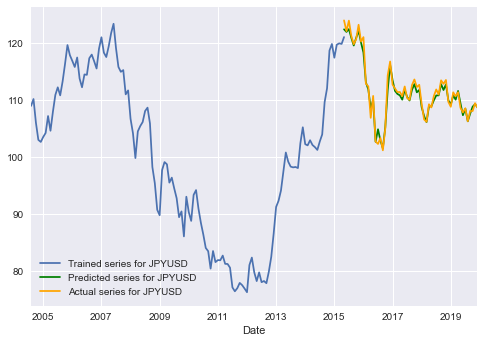

In [34]:
yhat4 = pd.Series(ypred_test, index=y_test.index)
y_train.resample('M').last().plot(label='Trained series for JPYUSD')
yhat4.resample('M').last().plot(color='green',label='Predicted series for JPYUSD')
y_test.resample('M').last().plot(color = 'orange',label='Actual series for JPYUSD')
plt.legend()

In [32]:
model_evaluate(y_test,yhat4 ,y_train, 'JPYUSD')

,MAE,MSE,RMSE,MAPE,sMAPE,MASE
Test vs Pred - JPYUSD,0.590313,0.607483,0.779412,0.005232,0.005246,1.300858
